In [1]:
import toto
from toto.inputs.nc import NCfile
from distribution_toolbox import get_peaks,do_EVA_water,plot_kde
import numpy as np
import matplotlib.pyplot as plt

fig import only supported on Windows


/usr/local/lib/python3.8/dist-packages/wafo-0.4.0-py3.8-linux-x86_64.egg/wafo/kdetools/demo.py:14: UserWarning: fig import only supported on Windows
  warnings.warn('fig import only supported on Windows')


In [2]:
folderin='/home/remy/projects/019_stormsurge/storm_surge_data/nz_tidal_gauges/linz/processed/'
filein='AUCT_processed.nc'

In [3]:
folderout='/home/remy/projects/019_stormsurge/storm_surge_data/nz_tidal_gauges/linz/processed/exemple'

In [4]:
# Parameters to find peaks
threshold_type='percentile' # or 'value'
thresh=95.0
min_peak_over_threshold=3
min_time_interval=24 # in hours
time_blocking='Annual'


In [5]:
# Parameter for the distribution
distribution='GPD' # can be 'Weibull','Gumbel','GPD' or 'GEV
method='ml' # 'pkd','pwm','mom' or 'ml'
surge_mode='Positive only' # 'Negative only' or 'Both (neg and pos)'

In [6]:
# Import processed file
filename=r'/home/remy/projects/019_stormsurge/storm_surge_data/nz_tidal_gauges/linz/processed/AUCT_processed.nc'
df=NCfile(filename)._toDataFrame()[0]

In [7]:
# prepare the dataframe
dfout = df.copy()
dfout['positive_surge']=df['ss']
dfout['negative_surge']=df['ss']*-1.
dfout['positive_tide']=df['tide']
dfout['negative_tide']=df['tide']*-1.
sint=(df.index[1]-df.index[0]).total_seconds()

In [8]:
# choose which surge we are studying
if surge_mode=='Both (neg and pos)':
    surges=['positive_','negative_']
elif surge_mode=='Positive only':
    surges=['positive_']
elif surge_mode=='Negative only':            
    surges=['negative_']

In [9]:
pks_opt={}

if threshold_type=='percentile':
    sort_data=np.sort(np.abs(dfout['ss'].values))
    sort_data=sort_data[~np.isnan(sort_data)]
    pks_opt['height']=sort_data[int(np.round(len(sort_data)*(thresh/100)))]

else:
    pks_opt['height']=thresh

pks_opt['distance']=min_time_interval*(sint/3600)

/usr/local/lib/python3.8/dist-packages/wafo-0.4.0-py3.8-linux-x86_64.egg/wafo/stats/estimation.py:1618: UserWarning: P-value is on the conservative side (i.e. too large) due to ties in the data!
  warnings.warn(


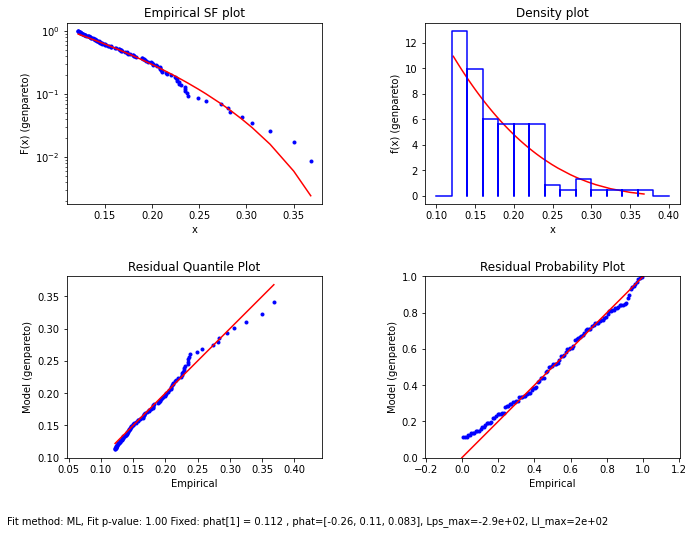

In [10]:
for surge in surges:
    peaks_index=get_peaks(dfout,surge+'surge',
              time_blocking=time_blocking,
              peaks_options=pks_opt,
              min_peak=min_peak_over_threshold)

    # in case there is some month with no peaks
    keys=list(peaks_index.keys())
    for key in keys:
        if len(peaks_index[key])==0:
            peaks_index.pop(key)

    eva_stats=do_EVA_water(peaks_index,dfout,surge+'surge',surge+'tide',distribution,method,time_blocking,pks_opt['height'],tide_join_prob=False)
#     plot_kde(eva_stats['Annual']['Omni'][surge+'surge']['el_resJP'],eva_stats['Annual']['Omni'][surge+'surge']['et'],
#              'KDE for Annual %s surge' % surge)
    eva_stats['Annual']['Omni'][surge+'surge']['phat'].plotfitsummary()
    plt.show()


In [11]:
# try with Pywextreme
from pyextremes import EVA
from scipy.stats import genextreme, gumbel_r


In [12]:
model = EVA(data=dfout['positive_surge'])

/home/remy/.local/lib/python3.8/site-packages/pyextremes/eva.py:110: RuntimeWarning: 16,254 Null values found in `data` - removing invalid entries
  warnings.warn(message=message, category=RuntimeWarning)


In [13]:
model.get_extremes(
    method='POT',threshold=pks_opt['height']
)

In [14]:
from scipy.stats import genextreme
model.fit_model(
    distribution=gumbel_r,model='MLE'
)

/home/remy/.local/lib/python3.8/site-packages/pyextremes/eva.py:866: RuntimeWarning: 'gumbel_r' distribution is not recommended to be used with extremes extracted using the 'POT' method, 'genpareto' or 'expon' should be used per the Pickands–Balkema–de Haan theorem
  warnings.warn(


                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                positive_surge      Size:                              89,390
Start:                      February 2010      End:                            June 2020
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                126      Extraction method:                    POT
Type:                                high      Threshold:                     0.12200001
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

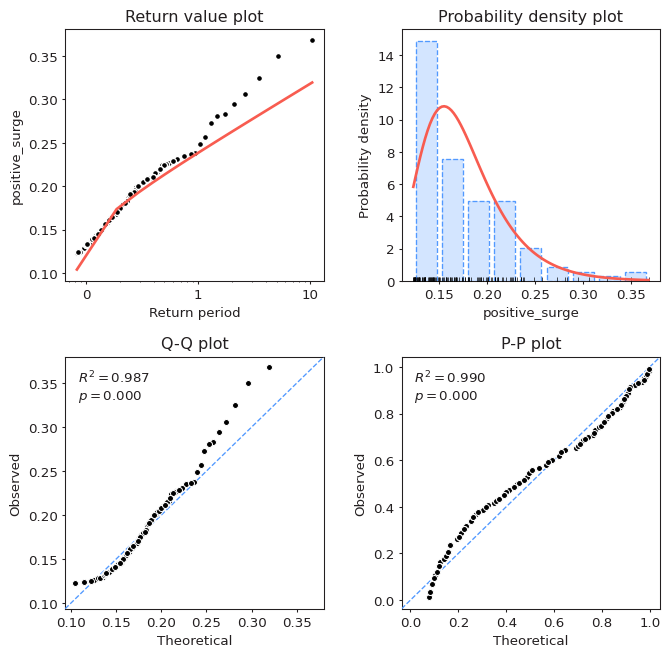

In [15]:
model.plot_diagnostic()
print(model)
plt.show()